In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

## Zadanie 1

In [54]:
def RTable(img, threshold):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, bin = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    bin = cv2.morphologyEx(bin, cv2.MORPH_CLOSE, np.ones((3,3)))
    bin = ~bin.astype(np.uint8)
    plt.imshow(bin, cmap='gray')
    plt.show()

    contours, hierarchy = cv2.findContours(bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    plt.imshow(cv2.drawContours(img, contours , -1, (255,0,0) ))
    plt.show()

    sobelx = cv2.Sobel(bin, cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(bin,cv2.CV_64F,0,1,ksize=5)
    sobelx = sobelx/np.amax(sobelx)
    sobely = sobely/np.amax(sobely)
    gradient = np.sqrt(sobelx**2 + sobely**2)
    gradient = gradient/np.amax(gradient)
    plt.imshow(sobelx.astype(np.float32))
    plt.show()
    plt.imshow(sobely.astype(np.float32))
    plt.show()
    plt.imshow(gradient.astype(np.float32))
    plt.show()
    alpha = np.arctan2(sobelx,sobely)
    plt.imshow(alpha.astype(np.float32))
    plt.show()

    moments_img = cv2.moments(bin, 1)
    RTable = [[] for _ in range (360) ]
    xc, yc = (moments_img['m01']/moments_img['m00'], moments_img['m10']/moments_img['m00'] )
    for i in range(contours[0].shape[0]):
        (x,y) = contours[0][i,0,:]
        alpha_t = -np.arctan2(xc-x,yc-y)+np.pi/2
        norm = np.sqrt((xc-x)**2+(yc-y)**2)
        theta = round(alpha[x,y]*360/(2*np.pi)+90)
        RTable[theta].append((norm,alpha_t))
    
    return RTable, contours, xc, yc, gradient


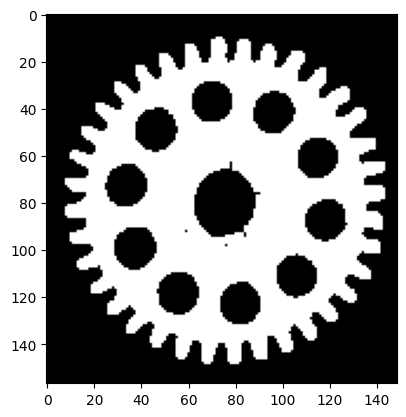

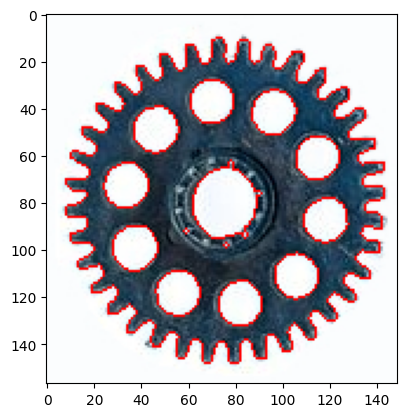

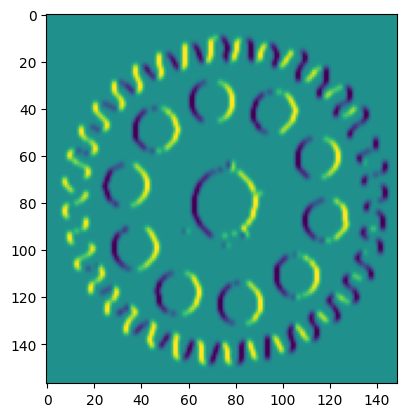

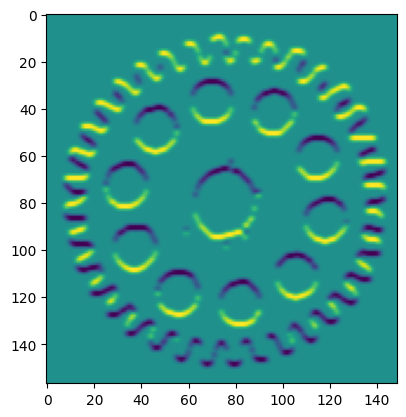

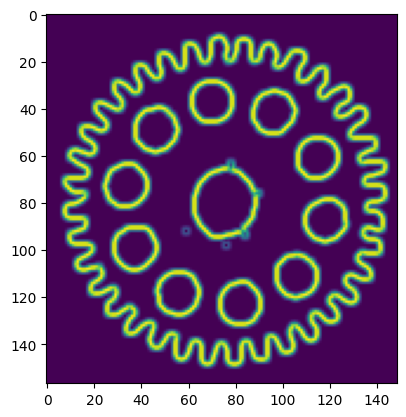

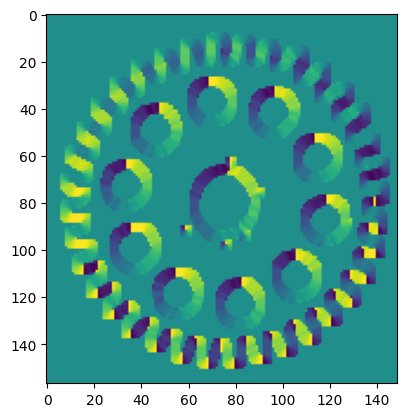

In [55]:
trybik = cv2.imread('trybik.jpg')
table, contours, xc, yc, gradient = RTable(trybik, 225)

In [56]:
def find(img, threshold, rtable, contours, xc, yc, gradient):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    th, bin = cv2.threshold(img_gray, threshold, 255 , cv2.THRESH_BINARY)
    bin = ~bin
    bin = cv2.morphologyEx(bin, cv2.MORPH_CLOSE, np.ones((3,3)))
    plt.imshow(bin, cmap='gray')
    plt.show()

    hough = np.zeros(np.array(bin.shape)+40)
    sobelx = cv2.Sobel(bin, cv2 . CV_64F ,1 ,0 , ksize =5)
    sobely = cv2 . Sobel (bin, cv2 . CV_64F ,0 ,1 , ksize =5)
    sobelx = sobelx/np.amax(sobelx)
    sobely = sobely/np.amax(sobely)
    gradient = np.sqrt(sobelx**2 + sobely**2)
    gradient = gradient/np.amax(gradient)
    alpha = np.arctan2(sobelx,sobely)
    plt.imshow(alpha.astype(np.float32))
    plt.show()

    for i in range(gradient.shape[0]):
        for j in range(gradient.shape[1]):
            if(gradient[i,j]>0.5):
                fi = alpha[i,j]
                for pair in rtable[round(fi*360/(2*np.pi)+90)]:
                    (r, alp) = pair
                    x1 = round(r* np . cos ( alp ) + i) #+ img_.shape[0]//2
                    y1 = round(r* np . sin ( alp ) + j) #+ img_.shape[1]//2
                    hough[x1,y1] += 1
    plt.imshow(6*hough.astype(np.float32)/np.max(hough.astype(np.float32)),cmap='gray')
    plt.show()

    # [ m_x ], [ m_y ] = np . where ( hough . max () == hough )
    temp = list(contours[0].shape)
    temp.insert(0, 1)
    # contour_temp = tuple((np.array(contours)-np.array([xc, yc])+np.array([m_x,m_y])))

    plt.imshow(img)
    max_lst = []
    for max in range(0, 4):
        temp = np.unravel_index(np.argmax(hough), hough.shape)
        max_lst.append(temp)
        hough[temp[0]-10:temp[0]+10, temp[1]-10:temp[1]+10] = 0
        plt . plot ([ temp[1] ], [ temp[0] ] ,'*', color ='r')

    plt.imshow(img)
    for (x,y) in max_lst:
        cnt = deepcopy(np.array(contours,dtype=np.ndarray))
        for i in range(cnt.shape[0]):
            for j in range(cnt[i].shape[0]):
                for k in range(cnt[i].shape[1]):
                    cnt[i][j,k,:] -= np.array([yc, xc],dtype=np.int32)-np.array([y,x],dtype=np.int32)

        cv2.drawContours( img, cnt , -1, (255,0,0) )
        plt . plot ([ y ], [ x ] ,'*', color ='r')
    plt.imshow(img)

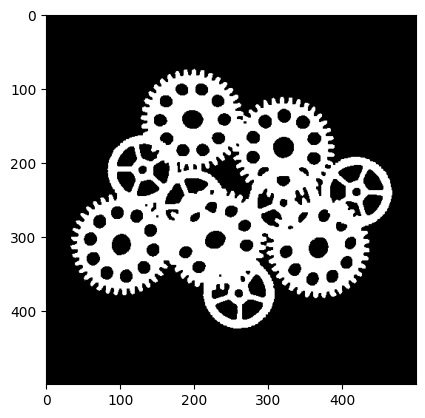

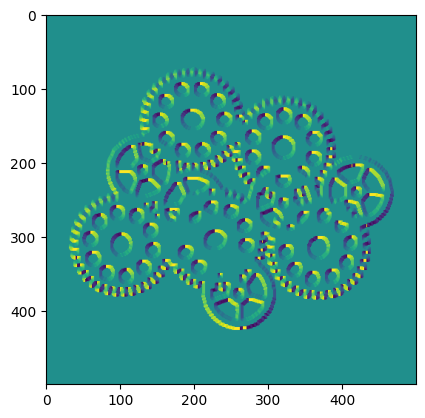

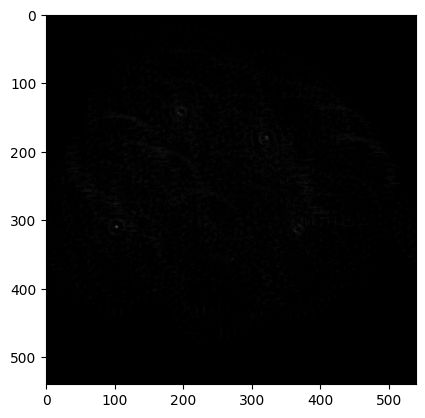

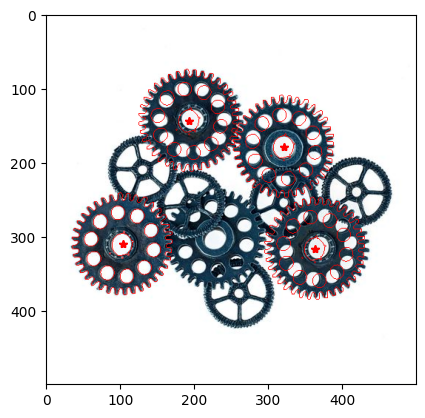

In [57]:
img = cv2.imread("trybiki2.jpg")
find(img, 225, table, contours, xc, yc, gradient)

## Task 2

In [73]:
def RTable_2(img, threshold):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, bin_img = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)
    bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, np.ones((3, 3), dtype=np.uint8))

    plt.imshow(bin_img, cmap='gray')
    plt.show()

    contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        raise ValueError("No contours found.")

    # Compute center of shape
    M = cv2.moments(bin_img)
    xc = M['m10'] / M['m00']
    yc = M['m01'] / M['m00']

    # Compute gradient orientation
    sobelx = cv2.Sobel(bin_img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(bin_img, cv2.CV_64F, 0, 1, ksize=5)
    alpha = np.arctan2(sobely, sobelx)

    plt.imshow(alpha, cmap='gray')
    plt.colorbar()
    plt.show()

    # Initialize R-table
    R_table = [[] for _ in range(360)]

    for (x, y) in contours[0].squeeze():
        dx = xc - x
        dy = yc - y
        r = np.hypot(dx, dy)
        phi = np.arctan2(dy, dx)

        theta = int((np.degrees(alpha[y, x]) + 90) % 360)
        R_table[theta].append((r, phi))

    return R_table, contours, xc, yc, alpha

In [74]:
def find_2(img, threshold, rtable, contours, xc, yc, gradient_template):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, bin_img = cv2.threshold(img_gray, threshold, 255, cv2.THRESH_BINARY_INV)
    bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, np.ones((3, 3), dtype=np.uint8))

    plt.imshow(bin_img, cmap='gray')
    plt.show()

    angle_bins = 36
    angle_step = 2 * np.pi / angle_bins
    hough = np.zeros(bin_img.shape + (angle_bins,), dtype=np.float32)

    # Compute gradients
    sobelx = cv2.Sobel(bin_img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(bin_img, cv2.CV_64F, 0, 1, ksize=5)
    gradient = np.hypot(sobelx, sobely)
    gradient /= np.max(gradient)
    alpha = np.arctan2(sobely, sobelx)

    plt.imshow(alpha, cmap='gray')
    plt.colorbar()
    plt.show()

    for y in range(gradient.shape[0]):
        for x in range(gradient.shape[1]):
            if gradient[y, x] > 0.5:
                alpha_deg = (np.degrees(alpha[y, x]) + 90) % 360
                for d in range(angle_bins):
                    df_rad = d * angle_step
                    table_idx = int((alpha_deg - np.degrees(df_rad)) % 360)
                    for r, phi in rtable[table_idx]:
                        x0 = int(round(x - r * np.cos(phi + df_rad)))
                        y0 = int(round(y - r * np.sin(phi + df_rad)))
                        if 0 <= x0 < hough.shape[1] and 0 <= y0 < hough.shape[0]:
                            hough[y0, x0, d] += 1

    delta = 30
    maxima = []
    for _ in range(5):
        idx = np.argmax(hough)
        y0, x0, angle_idx = np.unravel_index(idx, hough.shape)
        maxima.append((x0, y0, angle_idx))
        hough[max(0, y0 - delta):y0 + delta, max(0, x0 - delta):x0 + delta, :] = 0

    # Show detections
    plt.imshow(img)
    for (x0, y0, _) in maxima:
        plt.plot(x0, y0, '*', color='red')
    plt.title("Znalezione zębatki")
    plt.show()

    # Draw rotated contours
    for (x0, y0, angle_idx) in maxima:
        df_rad = angle_idx * angle_step
        cnt = [c.copy() for c in contours]

        for i in range(len(cnt)):
            for j in range(len(cnt[i])):
                pt = cnt[i][j][0].astype(np.float32)
                pt_centered = pt - np.array([xc, yc], dtype=np.float32)
                rot_x = pt_centered[0] * np.cos(df_rad) - pt_centered[1] * np.sin(df_rad)
                rot_y = pt_centered[0] * np.sin(df_rad) + pt_centered[1] * np.cos(df_rad)
                cnt[i][j][0] = np.array([rot_x + x0, rot_y + y0], dtype=np.int32)

        cv2.drawContours(img, cnt, -1, (255, 0, 0), 1)

    plt.imshow(img)
    plt.title("Kontury")
    plt.show()

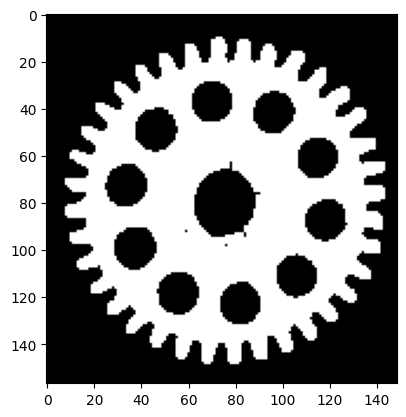

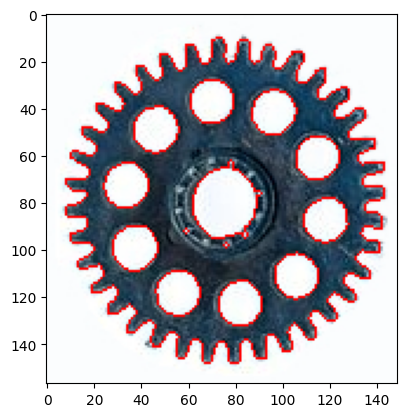

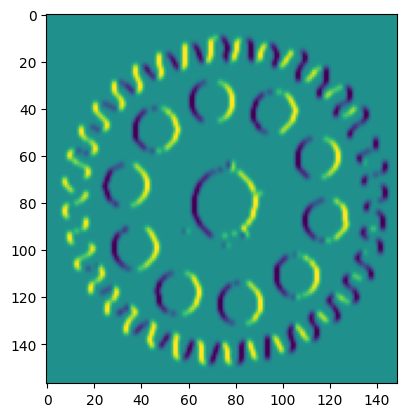

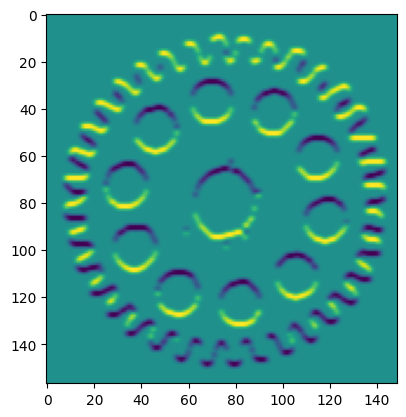

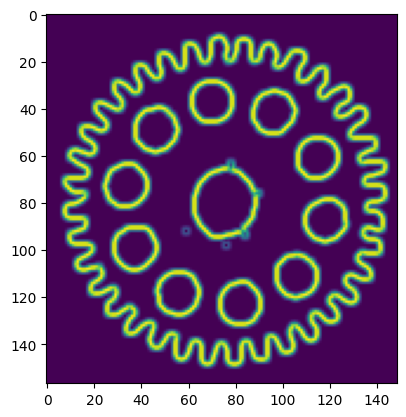

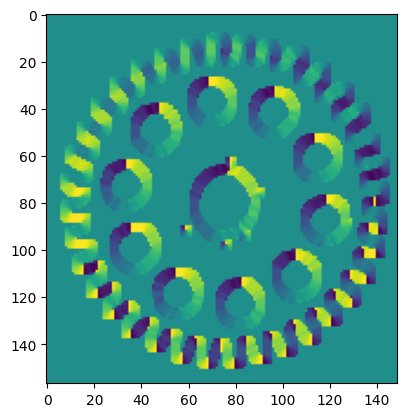

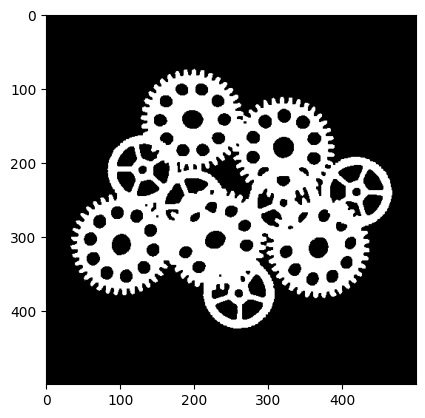

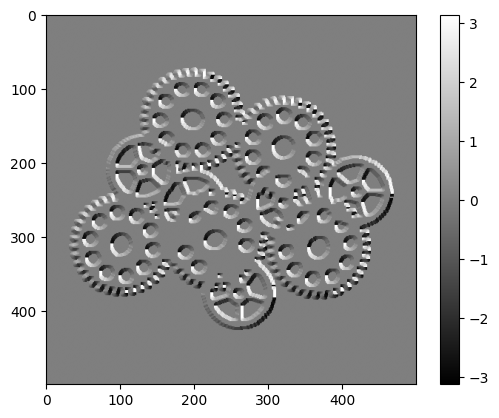

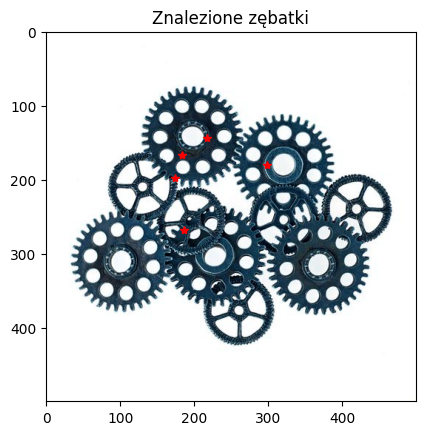

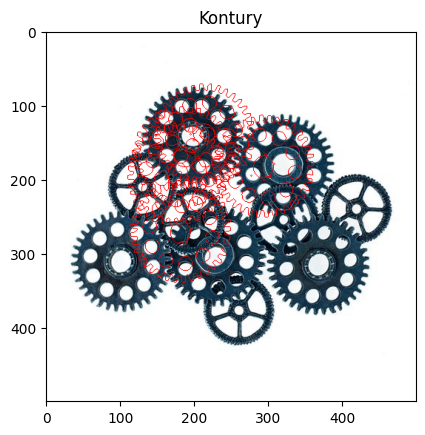

In [75]:
trybik2 = cv2.imread('trybik.jpg')
table2, contours2, xc2, yc2, gradient2 = RTable(trybik2, 225)

img2 = cv2.imread("trybiki2.jpg")
find_2(img2, 225, table2, contours2, xc2, yc2, gradient2)